Гафни Даниил, 306 группа, физический факультет МГУ

Решение двумерного уравнения теплопроводности

# В РАЗРАБОТКЕ

### Импортируем необходимые библиотеки

In [1]:
import time

import numpy as np

import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

import warnings

from IPython.display import clear_output, HTML, display, Image

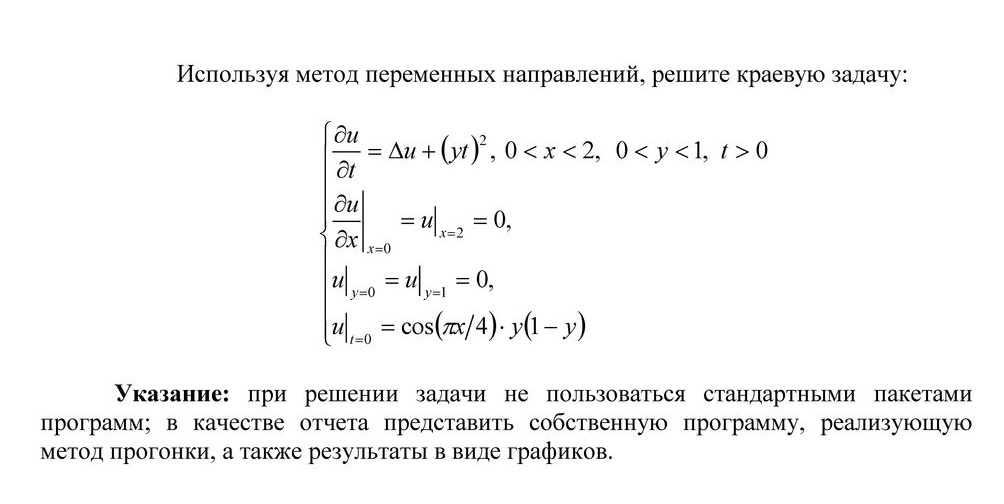

In [2]:
Image("task.jpg")

### Проведем необходимые настройки

In [6]:
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Оформление графиков plotly
layout = go.Layout(
    scene = dict( aspectmode='cube', camera = dict(eye=dict(x=-2, y=1.5, z=1)), 
    xaxis = dict(
        title='x',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(200, 200, 230)"),
                        
    yaxis = dict(
        title='y',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 200,230)"),
                        
    zaxis = dict(
        title='u(x, t)',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 230,200)",),),
    autosize=False,
    width=800, height=600,
    margin=dict(
        r=20, b=10,
        l=10, t=10),
    )
camera = dict(
    eye=dict(x=-2, y=2, z=1)
)

In [7]:
def TDMA(data, F):
    '''
    Метод прогонки.
        
    Параметры: 
        coeffs (numpy.array): Трехдианональная матрица коэффициентов уравнений.
        F (numpy.array): Массив правых частей уравнений.
    Вывод:
        (numpy.array): Массив искомых значений неизвестных.
    '''
        
    N = len(F)
    x = [0]*(N)
    A = []
    C = [data[0][0]]
    B = [data[0][1]]
    for i in range(1, N-1):
        A.append(data[i][i-1])
        C.append(data[i][i])
        B.append(data[i][i+1])
    A.append(data[-1][-2])
    C.append(data[-1][-1])

    alpha = [-B[0]/C[0]]*(N-1)
    beta = [F[0]/C[0]]*(N-1)
    
    # Прямой ход прогонки
    for i in range(1, N-1):
        alpha[i] = -B[i]/(A[i-1]*alpha[i-1] + C[i])
        beta[i] = ((F[i] - A[i-1]*beta[i-1])/(A[i-1]*alpha[i-1] + C[i]))  
    x[-1] = (F[-1] - A[-1]*beta[-1]) / (C[-1] + A[-1]*alpha[-1])
    
    # Обратный ход прогонки
    for i in reversed(range(N-1)):
        x[i] = alpha[i]*x[i+1] + beta[i]
        
    return(np.array(x))

Демонстрация работы метода прогонки

In [8]:
data = np.array([
    [2, -1, 0, 0, 0],
    [-3, 8, -1, 0, 0],
    [0, -5, 12, 2, 0],
    [0, 0, -6, 18, -4],
    [0, 0, 0, -5, 10]
])
F = np.array([
    -25, 72, -69, -156, 20
])
TDMA(data, F)

array([-10.,   5.,  -2., -10.,  -3.])

In [13]:
class HeatEquationSolver_2():
    '''
    Класс для численного решения двумерного уравнения теплопроводности.
    '''
    def __init__(self,
                 X_START=0, X_END=np.pi,
                 Y_START=0, Y_END=np.pi,
                 T_START=0, T_END=20,
                 N=5, M=5, J=5):
        
        self.X_START = X_START
        self.X_END = X_END
        self.Y_START = Y_START
        self.Y_END = Y_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = M
        self.J = J
        
        self.x = np.linspace(X_START, X_END, N)
        self.y = np.linspace(Y_START, Y_END, M)
        self.t = np.linspace(T_START, T_END, J)
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = self.t[1] - self.t[0]
    
    def initialize(self, a=1, f=lambda x, y, t:0, fi=lambda x, y:0,
                   alpha1x=0, alpha2x=0, beta2x=0, beta1x=0, mu1x=lambda y, t:0, mu2x=lambda y, t:0,
                   alpha1y=0, alpha2y=0, beta2y=0, beta1y=0, mu1y=lambda x, t:0, mu2y=lambda x, t:0):
        '''
        Задание коэффициентов и функций конкретной задачи.
        '''
        
        self.a = a
        self.f = f
        self.fi = fi
        
        self.alpha1x = alpha1x
        self.alpha2x = alpha2x
        self.beta1x = beta1x
        self.beta2x = beta2x
        self.mu1x = mu1x
        self.mu2x = mu2x
        
        self.alpha1y = alpha1y
        self.alpha2y = alpha2y
        self.beta1y = beta1y
        self.beta2y = beta2y
        self.mu1y = mu1y
        self.mu2y = mu2y
        
        self.u = np.zeros((self.J, self.N, self.M))
        
        self.u[0] = [[self.fi(x, y) for y in self.y] for x in self.x]  # Применение начального условия
        
    def calculate_layer(self, j):
        '''
        Метод, который вычисляет значения функции u(x, y, t) на временном слое номер j,
        используя предыдущий слой номер j-1.
        '''
        
        step_x = self.dx
        step_y = self.dt
        step_t = self.dt/2
          
        # Переход к промежуточному слою, задание коэффициентов для метода прогонки
        middle_layer = [np.array([0]*self.N)]*(self.M)
        for m in range(self.M):
            data = np.zeros((self.N, self.N))
            #Учет граничных условий
            data[0][0] = self.beta1x - self.alpha1x/step_x
            data[0][1] = self.alpha1x/step_x
            data[-1][-2] = -self.alpha2x/step_x 
            data[-1][-1] = self.alpha2x/step_x + self.beta2x
                
            for i in range(1, self.N - 1):
                data[i][i-1] = -self.a**2*step_t/step_x**2
                data[i][i] = (2*self.a**2*step_t/step_x**2 + 1)
                data[i][i+1] = -self.a**2*step_t/step_x**2
        
            F = [0]*self.N
            F[0], F[-1] = self.mu1x(self.y[m], self.t[j]+step_t), self.mu2x(self.y[m], self.t[j]+step_t)
            for k in range(1, self.N-1):
                F[k] = (self.f(self.x[k], self.y[m], self.t[j]+step_t)*step_t + self.u[j-1][k][m] + 
                        self.a**2*step_t/step_y**2 * (self.u[j-1][k-1][m] - 2*self.u[j-1][k][m] + self.u[j-1][k+1][m]))
                
            middle_layer[m] = TDMA(data, F)  # Применение метода прогонки
            
        middle_layer = np.array(middle_layer).T  # Транспонирование 

        # Переход к новому слою, задание коэффициентов для метода прогонки
        new_layer = [np.array([0]*self.M)]*(self.N)
        
        for n in range(self.N):
            data = np.zeros((self.M, self.M))
            # Учет граничных условий
            data[0][0] = self.beta1y - self.alpha1y/step_y
            data[0][1] = self.alpha1y/step_y
            data[-1][-2] = -self.alpha2y/step_y 
            data[-1][-1] = self.alpha2y/step_y + self.beta2y
        
        
            for i in range(1, self.M - 1):
                data[i][i-1] = -self.a**2*step_t/step_y**2
                data[i][i] = (2*self.a**2*step_t/step_y**2 + 1)
                data[i][i+1] = -self.a**2*step_t/step_y**2
        
            F = [0]*self.M
            F[0], F[-1] = self.mu1y(self.x[n], self.t[j]+2*step_t), self.mu2y(self.x[n], self.t[j]+2*step_t)
            for k in range(1, self.M-1):
                F[k] = (self.f(self.x[n], self.y[k], self.t[j]+2*step_t)*step_t + middle_layer[n][k] + 
                        self.a**2*step_t/step_x**2 * (middle_layer[n][k-1] - 2*middle_layer[n][k] + middle_layer[n][k+1]))
                
            new_layer[n] = TDMA(data, F)  # Применение метода прогонки
        
        new_layer = np.array(new_layer)
        
        return new_layer
           
    def calculate_u(self):
        print('Calculating...')
        for j in range(1, self.J):
            clear_output(wait = True)
            print(f'Progress: {round(j/(self.J-1), 2)*100}%')
            new_layer = self.calculate_layer(j)
            self.u[j] = new_layer
        
    def plot_state(self, n = 0, filename = 'OMM_Task_2_initial_conditions',
                       online = False):
        '''
        Метод, который строит график u(x, y, t) в момент времени на n% от временного интервала.
        
         Параметры:
            n (double): Число от 0 до 100 (при n > 100 считается, что n = 100).
        '''
        
        num = int(round(n/100*self.J, 0))
        if num>self.J-1:
            num = self.J-1
            
        data = [go.Surface(x = self.x, y = self.y, z = self.u[num].T, colorscale = 'YlGnBu')]
        fig = go.Figure(data = data, layout = layout)
        #fig['layout'].update(scene=dict(camera=camera))
        if online:
            display(plotly.plotly.iplot(fig, filename = filename))
        if not online:
            display(plotly.offline.iplot(fig, filename = filename))
        
    def plot_initial_state(self, filename = 'OMM_Task_2_state',
                       online = True):
        '''
        Метод, который строит график начального условия.
        '''
        
        self.plot_state(n = 0, filename = filename,
                       online = online)
    
    def show_evolution(self):
        '''
        Метод, который отображает анимацию эволюции u(x, y, t).
        '''
        
        # Create FigureWidget and add surface trace
        fig = go.Figure(layout = layout)
        surface = fig.add_surface(z=self.u[0].T, colorscale = 'YlGnBu')

        # Set axis ranges to fixed values to keep them from retting during animation
        fig.layout.scene.zaxis.range = [np.min(self.u), np.max(self.u)]
        fig.layout.scene.yaxis.range = [self.Y_START, self.Y_END]
        fig.layout.scene.xaxis.range = [self.X_START, self.X_END]

        frames = []
        for j in range(self.J):
            frames.append(go.Frame(data=[{'type': 'surface','x': self.x, 'y': self.y, 'z': self.u[j].T}]))

        fig.frames = frames

        fig.layout.updatemenus = [
            {
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 100, 'redraw': False},
                                 'fromcurrent': True, 'transition': {'duration': 100}}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                        'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.55,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }
        ]

        display(iplot(fig))

In [48]:
solver = HeatEquationSolver_2(N = 50, M = 40, J = 20, T_END = 3)
a = 1
def f(x, y, t):
    return np.cos(x) * np.exp(-t)
def fi(x, y):
    return 0
alpha1x = 1
alpha2x = 1
alpha1y = 0
alpha2y = 0
beta1x = 0
beta2x = 0
beta1y = 1
beta2y = 1
solver.initialize(a = a, f = f, fi = fi,
                  alpha1x = alpha1x, alpha2x = alpha2x, alpha1y = alpha1y, alpha2y = alpha2y,
                  beta1x = beta1x, beta2x = beta2x, beta1y = beta1y, beta2y = beta2y)

In [49]:
solver.plot_initial_state(online = False)

None

In [50]:
solver.calculate_u()

Progress: 100.0%


In [51]:
solver.plot_state(100, online = False)

None

Анимация

In [52]:
solver.show_evolution()

None